# 전체 지점 데이터 추출

In [ ]:
# !pip install ee
# !pip install geemap
# !pip install ipympl

In [1]:
import ee, geemap
import pandas as pd

In [2]:
geemap.ee_initialize()

In [3]:
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands([ndvi])

In [13]:
def maskS2clouds(image):
    qa = image.select('QA60')
    
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0)))
        
    return image.updateMask(mask)

In [125]:
# reducePoints의 날짜 추가 코드가 기능하지 않으므로
# 새로운 날짜 추가 기능을 해줄 코드를 작성해야함
## 아래 코드는 한 개 image 대상으로는 돌아가는데 Collection단위로 적용되게 할 방법을 찾아야함

def addDate(image):
    date = ee.Date(image.get('system:time_start')).format().getInfo().rename('DATE')
    return image.addBands([date])

# ee.Date(collection.first().get('system:time_start')).format().getInfo()

'2022-01-07T02:27:29'

In [5]:
def reducePoints(image):
    return image.reduceRegions(
                     collection = points,
                     reducer = ee.Reducer.mean(),
                     scale = 10)
                # .copyProperties(image, ['system:time_start'])\
                # .set('DATE', image.date().format('YYYY-MM-dd'))

In [6]:
table = geemap.shp_to_ee('.shp')
points = ee.FeatureCollection(table)

# geometry = geemap.geojson_to_ee('korea.geojson')

start_date = '2022-01-01'
end_date = '2022-02-01'

In [14]:
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
       .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
       .filterBounds(table)
       .filterDate(start_date, end_date)
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
       .map(addNDVI)
       .map(maskS2clouds)
)

In [15]:
result = collection.map(reducePoints).flatten()

---
# 데이터 저장 및 데이터프레임 생성

In [ ]:
# FeatureCollection -> csv로 내보내기
geemap.ee_to_csv(result, filename=f'S2_Total-{start_date}-{end_date}_timeseries.csv')

In [12]:
# FeatureCollection -> DataFrame으로 변환
## ee 오브젝트를 바로 df로 사용하고 싶은 경우 사용  (system:index가 df에 안들어옴..)
# result_df = geemap.ee_to_df(result)

## 이미지 개수가 5000개 이상이면 오류 발생함

In [17]:
# 내보낸 csv -> DataFrame으로 가져오기
result_df = pd.read_csv(f'S2_Total-{start_date}-{end_date}_timeseries.csv', encoding='utf-8')

## NA값 제거 및 컬럼 이름 변경

In [37]:
if 'system:index' in result_df.columns:
    S2 = result_df[['system:index', 'Location', 'BUFF_DIST', 'B2', 'B3', 'B4', 'B8', 'NDVI']].dropna() 
else:
    S2 = result_df[['Location', 'BUFF_DIST', 'B2', 'B3', 'B4', 'B8', 'NDVI']].dropna() 

In [ ]:
from datetime import datetime

S2.rename(columns={'B2':'Blue', 'B3':'Green', 'B4':'Red', 'B8':'NIR'}, inplace=True)
S2.rename(columns={'system:index':'DATE'}, inplace=True)
S2['DATE'] = S2['DATE'].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

In [39]:
S2.head(6)

,DATE,Location,BUFF_DIST,Blue,Green,Red,NIR,NDVI
1,2022-01-07,AMD,5,69.502488,179.348259,157.636816,1824.378109,0.843008
10,2022-01-07,AMD,10,75.086250,192.245000,167.407500,1870.890000,0.838265
19,2022-01-07,AMD,15,69.702282,193.190317,160.622705,1883.075125,0.845583
28,2022-01-07,AMD,20,62.674083,194.796929,153.726418,1917.150736,0.854010
37,2022-01-07,AMD,25,56.926379,195.976931,147.907121,1939.359278,0.860170
46,2022-01-07,AMD,30,52.770077,197.076270,142.614335,1960.400835,0.865630


- 결측치 제거한 데이터 정렬 및 .csv 내보내기

In [40]:
sorted_S2 = S2.reset_index().sort_values(by=['Location', 'index'])

In [41]:
sorted_S2.drop(axis=1, columns=['index']).to_csv(f'S2_Total-{start_date}-{end_date}_timeseries_clean.csv', encoding='utf-8', index=False)

---

# 지점별 관측 개수 시각화

In [69]:
import matplotlib.pyplot as plt

In [ ]:
# 그래프에 한글 출력 시 사용
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

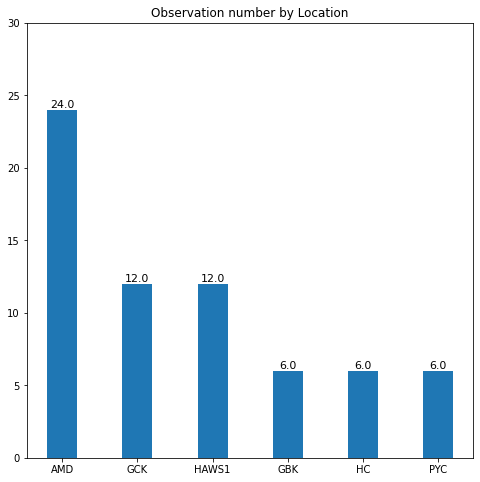

In [20]:
targetColumn = 'Location'
counts = S2[targetColumn].value_counts()

plt.figure(figsize=(8, 8))
plt.title('Observation number by Location')
bars = plt.bar(counts.index, counts, width=0.4)
plt.ylim(0, counts.max()*1.25) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, 
             height, f'{height:.1f}', ha='center', va='bottom', size = 11)
    
plt.show()

---
# 관측 지점별 위성 사진 확인

In [43]:
coords = result_df[['Location', 'Lon', 'Lat']].drop_duplicates()

In [44]:
coords_dict = {'GBK_coord' : [coords.iloc[0, 1], coords.iloc[0, 2]],
               'AMD_coord' : [coords.iloc[1, 1], coords.iloc[1, 2]],
               'WD_coord'  : [coords.iloc[2, 1], coords.iloc[2, 2]],
               'HC_coord'  : [coords.iloc[3, 1], coords.iloc[3, 2]],
               'PYC_coord' : [coords.iloc[4, 1], coords.iloc[4, 2]],
               'SC_coord'  : [coords.iloc[5, 1], coords.iloc[5, 2]],
               'JJ_coord'  : [coords.iloc[6, 1], coords.iloc[6, 2]],
               'GCK_coord' : [coords.iloc[7, 1], coords.iloc[7, 2]],
             'HAWS1_coord' : [coords.iloc[8, 1], coords.iloc[8, 2]], }

vis = {'bands': ['B4', 'B3', 'B2'],
       'min': 0,
       'max': 3000,
       'gamma':1.4  }

- target 변수에 관측지점 코드 입력하여 사용

In [57]:
target = 'GCK'
point = coords_dict[f'{target}_coord']

start_date = '2022-01-01'
end_date = '2022-05-01'

spot = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
       .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
       .filterDate(start_date, end_date)
       .filterBounds(ee.Geometry.Point(point))
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
       .map(addNDVI)
       .map(maskS2clouds))

# ee.Date(temp.first().get('system:time_start')).format().getInfo()

In [132]:
Map = geemap.Map()
Map.setCenter(point[0], point[1], 15)
Map.addLayer(ee.Image(spot.mean().clip(ee.Geometry.Point(point).buffer(250).bounds())), vis, 'Sentinel-2')
Map.addLayer(ee.Image().paint(ee.Geometry.Point(point).buffer(250).bounds(), 0, 1), {'palette': 'FF0000'}, 'Box Outline')
Map.addLayer(ee.Image().paint(ee.Geometry.Point(point).buffer(30).bounds(), 0, 1), {'palette': 'FFFF00'}, 'Center point')
Map

Map(center=[37.7484, 127.163], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

## 지점별 데이터 생성 및 전처리

In [59]:
def clipPoint(image):
    return image.clip(ee.Geometry.Point(point).buffer(250).bounds())\
                .reduceRegions(
                     collection = points,
                     reducer = ee.Reducer.mean(),
                     scale = 10)
                # .copyProperties(image, ['system:time_start'])\
                # .set('DATE', image.date().format('YYYY-MM-dd'))

In [60]:
spot_result = spot.map(clipPoint).flatten()

In [61]:
# ee 오브젝트 csv로 내보내지않고 바로 df로 사용할 경우 실행 (system:index 컬럼이 df로 안넘어옴..)
# spot_df = geemap.ee_to_df(spot_result)

In [ ]:
# ee 오브젝트를 csv로 내보냈다가 df로 불러오고 싶은 경우 사용 
geemap.ee_to_csv(spot_result, f'S2_{target}-{start_date}-{end_date}_timeseries.csv')
spot_result_df = pd.read_csv(f'S2_{target}-{start_date}-{end_date}_timeseries.csv', encoding='utf-8')

spot_result_cleaned = spot_result_df.reset_index().sort_values(by=['Location', 'index'])
if 'system:index' in spot_result_cleaned.columns:
    spot_result_cleaned = spot_result_cleaned[['system:index', 'Location', 'BUFF_DIST', 'B2', 'B3', 'B4', 'B8', 'NDVI']].dropna() 
else:
    spot_result_cleaned = spot_result_cleaned[['Location', 'BUFF_DIST', 'B2', 'B3', 'B4', 'B8', 'NDVI']].dropna() 

spot_result_cleaned.rename(columns={'B2':'Blue', 'B3':'Green', 'B4':'Red', 'B8':'NIR'}, inplace=True)
spot_result_cleaned.rename(columns={'system:index':'DATE'}, inplace=True)
spot_result_cleaned['DATE'] = spot_result_cleaned['DATE'].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")
spot_result_cleaned.to_csv(f'S2_{target}-{start_date}-{end_date}_timeseries_clean.csv', encoding='utf-8', index=False)

spot_df = pd.read_csv(f'S2_{target}-{start_date}-{end_date}_timeseries_clean.csv', encoding='utf-8')

In [66]:
spot_df['Location'].value_counts()

GCK    60
Name: Location, dtype: int64

In [104]:
target_df = spot_df.copy()

## 관측 밴드값 그래프

### 날짜별 밴드값 조회

In [105]:
vaild_date = target_df['DATE'].value_counts().index
vaild_date

Index(['2022-01-07', '2022-01-17', '2022-02-06', '2022-02-11', '2022-03-03',
       '2022-03-08', '2022-04-02', '2022-04-07', '2022-04-17', '2022-04-27'],
      dtype='object')

- targetDate 변수에 조회 날짜의 인덱스 입력
-  targetBand 변수에 조회 밴드 입력

In [129]:
targetDate = vaild_date[3]
targetBand = 'NIR'

In [130]:
target_line = target_df[target_df['DATE'] == targetDate].set_index(['BUFF_DIST']).loc[:, targetBand].T
target_line

BUFF_DIST
5     1361.126316
10    1388.348214
15    1423.828732
20    1437.492594
25    1440.307522
30    1430.193318
Name: NIR, dtype: float64

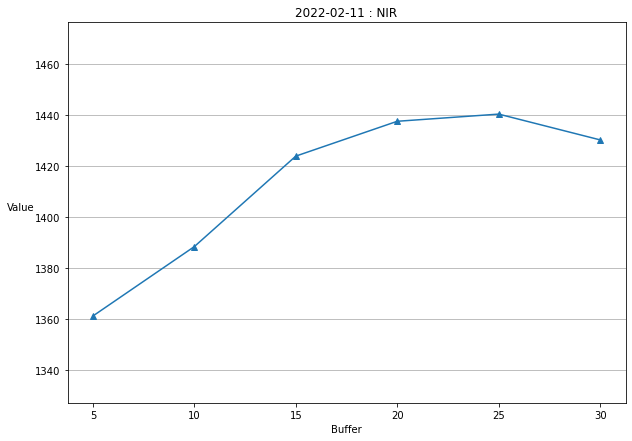

In [131]:
plt.plot(target_line, label = targetBand, marker='^')
plt.xlabel('Buffer')
plt.ylabel('Value', rotation=0, labelpad=14)
plt.ylim(target_line.min() * 0.975, target_line.max() * 1.025)
plt.title(f'{targetDate} : {targetBand}')
plt.grid(axis='y')
plt.show()

### 밴드별 전체 날짜 평균값 조회

In [109]:
target_mean = target_df.groupby(['BUFF_DIST']).mean()
target_mean.loc[:, 'NDVI'].T

BUFF_DIST
5     0.669248
10    0.672606
15    0.675778
20    0.676173
25    0.672285
30    0.665996
Name: NDVI, dtype: float64

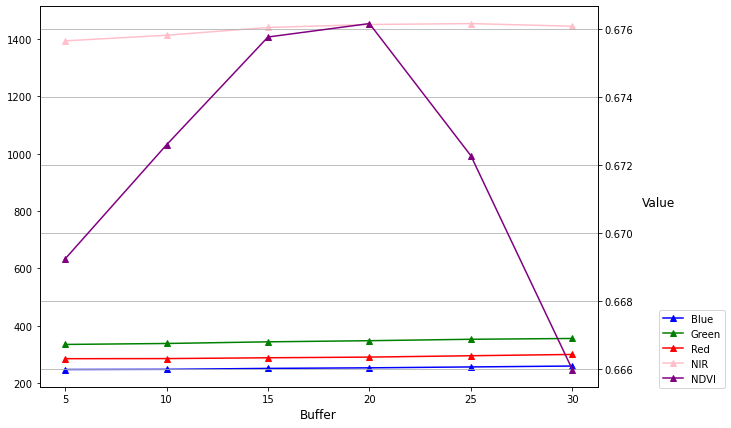

In [110]:
plt.rcParams['figure.figsize'] = (10, 7)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Buffer', size=12)
blueLine = ax1.plot(target_mean.loc[:, 'Blue'].T, marker='^', color='b', label='Blue')
greenLine = ax1.plot(target_mean.loc[:, 'Green'].T, marker='^', color='g', label='Green')
redLine = ax1.plot(target_mean.loc[:, 'Red'].T, marker='^', color='r', label='Red')
NIRLine = ax1.plot(target_mean.loc[:, 'NIR'].T, marker='^', color='pink', label='NIR')


ax2 = ax1.twinx()
ax2.set_ylabel('Value', rotation=0, size=12, labelpad=25)
NDVILine = ax2.plot(target_mean.loc[:, 'NDVI'].T, marker='^', color='purple', label='NDVI')

lines = blueLine + greenLine + redLine + NIRLine + NDVILine
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.1, 0.1))
plt.grid(axis='y')
plt.show()